In [ ]:
import sys
print(sys.version)

3.8.10 (default, Mar 13 2023, 10:26:41) 
[GCC 9.4.0]


In [ ]:
import os

In [ ]:
import findspark
findspark.init()

In [ ]:
# Start Apache Spark Session & Context
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Recommendor System').master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

print('Master: ', spark.sparkContext.master)
print('Cores: ', spark.sparkContext.defaultParallelism)


23/05/16 01:00:56 WARN Utils: Your hostname, saumya-ubuntu resolves to a loopback address: 127.0.1.1; using 10.10.81.69 instead (on interface eno1)
23/05/16 01:00:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/16 01:00:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Master:  local[*]
Cores:  8


In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark.sparkContext)

/home/saumya/opt/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
spark

In [ ]:
# Required Later
sqlContext.sparkSession.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [ ]:
!pip install koalas

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import random
from pprint import pprint
from matplotlib.lines import Line2D


#Pandas equivalent for spark
import databricks.koalas

# PySpark Utilities
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.sql.functions import col

# Random Seed
SEED = 1300

# Set-up
plt.style.use('seaborn')

/home/saumya/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_13710/3566072659.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
!ls

 EmpViewDepthMoniLogs.html
 EmpViewPowerMoniLogs.html
 EmpViewProjectwiseTasks.html
 EmpViewSSMoniLogs.html
 patient_category-07-02.csv_0.ods
 projects
'Reading Material'
'Recommendor_System_Books (1).ipynb'
 Recommendor_System_Books.ipynb
 SelectPowerMoniEmp.html
'Study Material'
 test.py
 treasure_hunt.mp4
 underlying_medical_condition-07-01.csv_1.ods
 ViewPowerMoniLogs.html


In [ ]:
# Path to Data Folder
DATA_PATH = "projects/BX-CSV-Dump/"

# Path to Results Folder
RESULTS_PATH = "projects/BX-CSV-Dump/Results/"

In [ ]:
class BookDatasets(object):
    """
    Class for loading and preprocesing Book Dataset
    """
    def __init__(self, ratings, Books,
                 debug=True, debugLimit=10000):
        # Load Existing Data
        if debug:
            debugLimit = debugLimit
            ratings = ratings.limit(debugLimit)
        else:
            ratings = ratings      

        self.ratings = ratings
        self.books = Books
        users = ratings.select("User-ID").distinct()
        self.users = users

    def preprocessing(self):
        # Preprocess MovieLens Ratings
        self.ratings = self.ratings.withColumn('Book-Rating',
              F.col('Book-Rating').cast('double')) \
              .withColumn('User-ID', F.col('User-ID').cast('int')) \
              .withColumn('ISBN', F.col('ISBN').cast('int'))

        # Binarize Books Ratings (if rating >= 3.0, then 1.0, else 0.0)
        udf_scale_ratings = F.udf(lambda x: x - 2.5, DoubleType())
        udf_binary_ratings = F.udf(lambda x: 1.0 if x > 0.0 else 0.0, DoubleType())

        self.ratings = self.ratings \
        .withColumn('ratingsScaled', udf_scale_ratings(F.col('Book-Rating'))) \
        .withColumn('ratingsBinary', udf_binary_ratings(F.col('ratingsScaled')))
        
        #print(1)

    def get_ratings(self):
        return self.ratings

    def get_books(self):
        return self.books

    # Displaying Null Values
    def spark_df_display_null_values(sparkDf):
        print('NaN values ?')
        sparkDf.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in sparkDf.columns]).show()

        print('Null values ?')
        sparkDf.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in sparkDf.columns]).show()

In [ ]:
%%time

# Set to True if only testing
debug = False

# Load Datasets
books = sqlContext.read\
            .format("com.databricks.spark.csv")\
            .options(header= "true",sep=';')\
            .option("inferschema", "true")\
            .option("mode", "DROPMALFORMED")\
            .load(DATA_PATH + "BX-Books.csv")


ratings = sqlContext.read \
            .format("com.databricks.spark.csv")\
            .options(header= "true",sep=';')\
            .option("inferschema", "true")\
            .option("mode", "DROPMALFORMED")\
            .load(DATA_PATH + "BX-Book-Ratings.csv")

# Data Preprocessing

books.show()

BookDatasets = BookDatasets(ratings=ratings, Books=books,
                                      debug=debug)

BookDatasets.preprocessing()
dfRatings = BookDatasets.get_ratings() 
dfBooks= BookDatasets.get_books()

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|0195153448| Classical Mythology|  Mark P. O. Morford|               2002|Oxford University...|http://images.ama...|http://images.ama...|http://images.ama...|
|0002005018|        Clara Callan|Richard Bruce Wright|               2001|HarperFlamingo Ca...|http://images.ama...|http://images.ama...|http://images.ama...|
|0060973129|Decision in Normandy|        Carlo D'Este|               1991|     HarperPerennial|http://images.ama...|http://images.ama...|http://images.ama...|
|0374157065|Flu: The Story of...|    Gina Bari

In [ ]:
dfRatingsKdf = dfRatings.to_koalas()

23/05/16 01:01:47 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


23/05/16 01:01:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/16 01:01:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/16 01:01:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/05/16 01:01:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/16 01:01:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/05/16 01:01:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/16 01:01:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/16 01:01:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/16 01:01:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/16 01:01:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/16 01:01:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


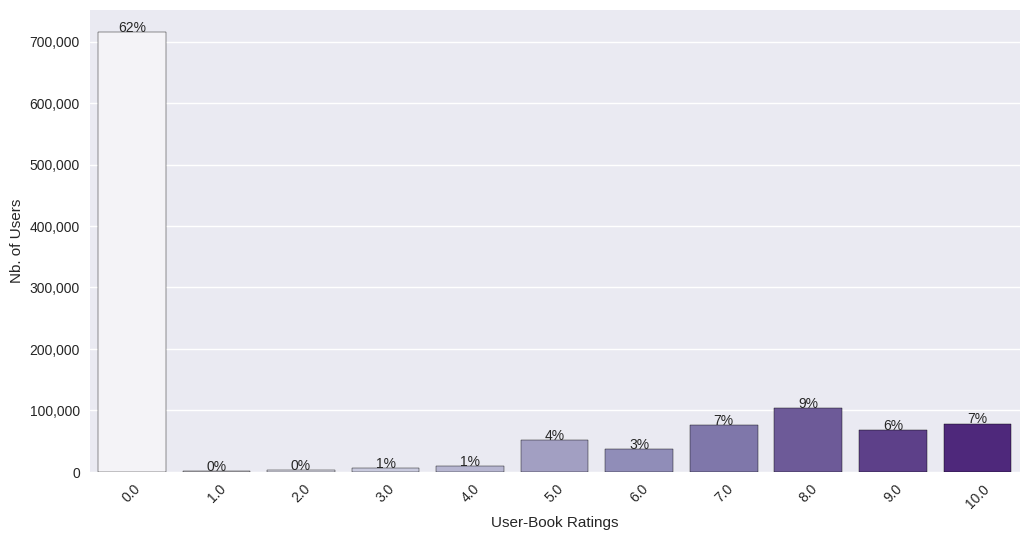

CPU times: user 684 ms, sys: 441 ms, total: 1.13 s
Wall time: 3.68 s


In [ ]:
%%time
BookRatingDistGroup = dfRatingsKdf['Book-Rating'].value_counts().sort_index().reset_index().to_pandas()

# Create Matplotlib Figure
fig, ax = plt.subplots(figsize=(12,6))

# Main Figure: Seaborn Barplot
sns.barplot(data=BookRatingDistGroup, x='index', y='Book-Rating',
            palette='Purples', edgecolor="black", ax=ax)

# Set Xaxis and Yaxis
ax.set_xlabel("User-Book Ratings")
ax.set_ylabel('Nb. of Users')
ax.tick_params(axis='x', rotation=45)

# Add thousand separators to Yaxis labels
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add percentage text on top of each bar
total = BookRatingDistGroup['Book-Rating'].sum()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 350, '{0:.0%}'.format(height / total), ha="center") 

# Display plot
plt.show()

In [ ]:
ratingsPrepare = dfRatings.withColumn("User-Id", F.col("User-Id").cast('int')) \
                          .withColumn("ISBN", F.col("ISBN").cast('int'))

dfRatingsTrain, dfRatingsTest = ratingsPrepare.randomSplit([0.8, 0.2],
                                                           seed=SEED)

In [ ]:
dfRatingsTest.show()

+-------+----------+-----------+-------------+-------------+
|User-Id|      ISBN|Book-Rating|ratingsScaled|ratingsBinary|
+-------+----------+-----------+-------------+-------------+
|      7|  34542252|        0.0|         -2.5|          0.0|
|      8| 374157065|        0.0|         -2.5|          0.0|
|      8| 679425608|        0.0|         -2.5|          0.0|
|      8| 771074670|        0.0|         -2.5|          0.0|
|      8|1558746218|        0.0|         -2.5|          0.0|
|      8|1881320189|        7.0|          4.5|          1.0|
|     10|      null|        6.0|          3.5|          1.0|
|     14|  61076031|        5.0|          2.5|          1.0|
|     16| 345402871|        9.0|          6.5|          1.0|
|     17| 553278398|        0.0|         -2.5|          0.0|
|     19| 375759778|        7.0|          4.5|          1.0|
|     32|  60168013|        8.0|          5.5|          1.0|
|     36|      null|        0.0|         -2.5|          0.0|
|     38|      null|    

In [ ]:
### Accuracy Metrics
def catalog_coverage(predicted, catalog, k):
    
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = L_predictions/(len(catalog)*1.0)
    return catalog_coverage


def get_rec_sys_results(relevantDocumentsDf, dfBooks):
    """
    Returns dictionnary of recommender system metrics
    Since Spark ML DataFrame-based doesn't have a
    specific function for evaluating the soundness
    of item recommendations, we will have to use
    Spark MLlib RDD-based API
    """
    # Transform Spark Dataframe into Spark RDD
    relevantDocuments = relevantDocumentsDf.rdd \
        .map(lambda row: (row.predictions, row.groundTruth))
    
    # Get Catalog Coverage
    booksCatalog = dfBooks.select("ISBN") \
                            .orderBy("ISBN") \
                            .distinct() \
                            .toPandas()
    predictions = relevantDocumentsDf.select("predictions").toPandas()
    predictionsList = predictions.values.tolist()
    predictionsList = [sublist[0] for sublist in predictionsList]
    cc = catalog_coverage(predicted=predictionsList,
                          catalog=booksCatalog, k=100)

    # Get Results
    metrics = RankingMetrics(relevantDocuments)
    pk20 = metrics.precisionAt(20)
    ndcg20 = metrics.ndcgAt(20)
    
    results = dict(Pk20=pk20, NDCGk20=ndcg20, CC=cc)
    
    return results



def format_recommendations(rowPreds):
    # From recommendations column extract only items
    # recommended and ignore ratings
    rowPredsList = [row.ISBN for row in rowPreds]
    return rowPredsList

udf_format_recommendations = F.udf(lambda x: format_recommendations(x),
                                   ArrayType(IntegerType()))

In [ ]:
class PopularityRecommenderModel(object):
    """
    Class for generating movie item recommendations based on movie popularity
    (from average ratings with logarithmic scaling factor that penalizes Books
    with few ratings). By default, only the top 10 rated Books are selected.

    """
    def __init__(self, ratingsTrain, ratingsTest):
        self.ratingsTrain = ratingsTrain
        self.ratingsTest = ratingsTest

    def generate_recommendations_for_all_users(self, topk=10):
        # Get list of top k rated Books
        topRated = self._get_top_k_best_books(topk=topk)

        # Compare most popular Books with user's personal preferences
        # Important: only keep recommendations with rating over 3/5
        results = self.ratingsTest \
                 .filter(F.col("ratingsBinary")==1.0) \
                 .withColumn('ISBN', F.col('ISBN').cast('int')) \
                 .orderBy('Book-Rating', ascending=False) \
                 .groupby("User-Id") \
                 .agg(F.collect_list("ISBN").alias('groundTruth')) \
                 .withColumn('predictions', F.array([F.lit(el)
                        for el in topRated])) \
                 .select(['User-Id', 'predictions', 'groundTruth'])

        return results

    def _get_top_k_best_books(self, topk):

        # Function
        def _get_mean_rating_w_log_penalty(arr):
            sumRatings, nbRatings = arr[0], arr[1]
            grade = (sumRatings / nbRatings) * math.log(nbRatings)
            return grade

        # UDF
        udf_mean_rating_w_log_penalty = F.udf(
            lambda arr: _get_mean_rating_w_log_penalty(arr),
            DoubleType()
        )

        # Get top k Best Rated Books
        ranking = self.ratingsTrain.groupBy('ISBN') \
                  .agg({'Book-Rating': 'sum', 'User-Id': 'count'}) \
                  .toDF('ISBN', 'sumRating', 'nbRatings')

        ranking = ranking \
          .withColumn("meanLogUserRating",
             udf_mean_rating_w_log_penalty(F.array("sumRating", "nbRatings"))
             ) \
          .sort(['meanLogUserRating', 'nbRatings'], ascending=[False, True]) \
          .limit(topk)

        self.topRatedBooks = ranking
        ratingsTop = [int(row.ISBN) for row in ranking.filter("ISBN IS NOT NULL").collect()]

        return ratingsTop

In [ ]:
%%time
pbrModel = PopularityRecommenderModel(dfRatingsTrain, dfRatingsTest)
resultsPop = pbrModel.generate_recommendations_for_all_users(topk=20)

CPU times: user 45.6 ms, sys: 8.89 ms, total: 54.5 ms
Wall time: 5.33 s


In [ ]:
%%time
resultsPop.limit(5).orderBy('User-Id').show(10)

+-------+--------------------+------------+
|User-Id|         predictions| groundTruth|
+-------+--------------------+------------+
|      8|[439139597, 43913...|[1881320189]|
|     10|[439139597, 43913...|          []|
|     14|[439139597, 43913...|  [61076031]|
|     16|[439139597, 43913...| [345402871]|
|     19|[439139597, 43913...| [375759778]|
+-------+--------------------+------------+

CPU times: user 14.1 ms, sys: 3.87 ms, total: 17.9 ms
Wall time: 6.1 s


In [ ]:
%%time
results = get_rec_sys_results(resultsPop, dfBooks)

/home/saumya/opt/spark/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


23/05/16 01:02:16 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:16 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:16 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:16 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:16 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:16 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:16 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:16 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:16 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:16 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:16 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:16 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:16 WARN RankingMetrics: E

23/05/16 01:02:17 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:17 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:17 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:17 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:17 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:17 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:17 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:17 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:17 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:17 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:17 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:17 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:17 WARN RankingMetrics: E

23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: E

23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:02:18 WARN RankingMetrics: E

In [ ]:
pprint(results)

{'CC': 7.001278654575335e-05,
 'NDCGk20': 0.0049290723480630416,
 'Pk20': 0.0013473053892215658}


In [ ]:
%%time
_ = pbrModel.generate_recommendations_for_all_users(topk=20)
pbrModel.topRatedBooks \
    .join(dfBooks.select(['ISBN', 'Book-Title']), 'ISBN') \
    .orderBy('meanLogUserRating', ascending=False) \
    .show(20, truncate=False)

+----------+---------+---------+------------------+------------------------------------------------------------+
|ISBN      |sumRating|nbRatings|meanLogUserRating |Book-Title                                                  |
+----------+---------+---------+------------------+------------------------------------------------------------+
|439139597 |1082.0   |157      |34.84622905341955 |Harry Potter and the Goblet of Fire (Book 4)                |
|439136350 |925.0    |139      |32.83732653342367 |Harry Potter and the Prisoner of Azkaban (Book 3)           |
|439064864 |936.0    |144      |32.30378644724401 |Harry Potter and the Chamber of Secrets (Book 2)            |
|590353403 |880.0    |135      |31.975124481672726|Harry Potter and the Sorcerer's Stone (Book 1)              |
|316666343 |4671.0   |1044     |31.098904007083632|The Lovely Bones: A Novel                                   |
|385504209 |3221.0   |687      |30.62685408333069 |The Da Vinci Code                            

In [ ]:
%%time
tempALS = ALS(maxIter=15, rank=10, regParam=0.1, nonnegative=True,
              userCol='User-Id', itemCol='ISBN', ratingCol='Book-Rating',
              coldStartStrategy='drop', implicitPrefs=True, seed=SEED)

mlALSFitted = tempALS.fit(dfRatingsTrain.filter("ISBN IS NOT NULL"))

23/05/16 01:02:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/16 01:02:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


CPU times: user 115 ms, sys: 29.8 ms, total: 145 ms
Wall time: 35.8 s


In [ ]:
mlALSFitted.save(RESULTS_PATH+"ALS_Book-Final")

23/05/16 01:03:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


23/05/16 01:03:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


In [ ]:
%%time
predictions = mlALSFitted.transform(dfRatingsTest.filter("ISBN IS NOT NULL"))
evaluator = RegressionEvaluator(metricName='rmse', labelCol='Book-Rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('RMSE (Test Set):', rmse)

RMSE (Test Set): 4.637414395560087
CPU times: user 19 ms, sys: 2.45 ms, total: 21.5 ms
Wall time: 3.28 s


In [ ]:
resultsALS = mlALSFitted.recommendForAllUsers(20)

resultsALS = resultsALS.withColumn('recommendations',
              udf_format_recommendations(F.col("recommendations"))) \
              .toDF('User-Id', 'predictions')

In [ ]:
resultsALSExpanded = resultsALS \
                        .withColumn("ISBN", F.explode("predictions")) \
                        .drop('predictions') \
                        .join(dfBooks.filter("ISBN IS NOT NULL"), "ISBN")

resultsALSKdf = resultsALSExpanded.to_koalas()

MostRecommendedBooksForAllUsers = resultsALSKdf.groupby(["ISBN", "Book-Title"])['User-Id'].count()
MostRecommendedBooksForAllUsers = MostRecommendedBooksForAllUsers.sort_values(ascending=False)

In [ ]:
MostRecommendedBooksForAllUsers

ISBN        Book-Title                                                                                          
312195516   The Red Tent (Bestselling Backlist)                                                                     14735
385504209   The Da Vinci Code                                                                                       13367
446310786   To Kill a Mockingbird                                                                                   11182
316666343   The Lovely Bones: A Novel                                                                               11079
142001740   The Secret Life of Bees                                                                                 10947
971880107   Wild Animus                                                                                             10937
446672211   Where the Heart Is (Oprah's Book Club (Paperback))                                                      10837
804106304   The Joy Luck Club    

In [ ]:
resultsALS = resultsALS \
                 .join(
                 dfRatingsTest \
                 .filter(F.col("ratingsBinary")==1.0) \
                 .withColumn('ISBN', F.col('ISBN').cast('int')) \
                 .groupby("User-Id") \
                 .agg(F.collect_list("ISBN").alias("groundTruth")),
                     'User-Id'
                 )

In [ ]:
%%time
resultsALSMetrics = get_rec_sys_results(resultsALS, dfBooks.filter("ISBN IS NOT NULL"))

/home/saumya/opt/spark/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


23/05/16 01:17:42 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:17:42 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:17:42 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:17:42 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:17:42 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:17:42 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:17:42 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:17:42 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:17:42 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:17:42 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:17:42 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:17:42 WARN RankingMetrics: Empty ground truth set, check input data
23/05/16 01:17:42 WARN RankingMetrics: E

In [ ]:
pprint(resultsALSMetrics)

{'CC': 0.0009691243611333228,
 'NDCGk20': 0.00890300806438851,
 'Pk20': 0.0027821777119207}


In [ ]:
results = {'CC': 7.001278654575335e-05,
           'NDCGk20': 0.0049290723480630416,
           'Pk20': 0.0013473053892215658}

In [ ]:
results['RMSE'] = 'N/A'
resultsALSMetrics['RMSE'] = rmse

In [ ]:
modelResults = pd.DataFrame([results, resultsALSMetrics],
                             index=['PopRec', 'CF-ALS'])

modelResults.transpose()

,PopRec,CF-ALS
CC,0.00007,0.000969
NDCGk20,0.00545,0.008903
Pk20,0.001485,0.002782
RMSE,N/A,4.637414


In [ ]:
%%time
dfRatingsTrain.filter(F.col("User-Id")==17).count()

CPU times: user 7.92 ms, sys: 0 ns, total: 7.92 ms
Wall time: 2.68 s


6

In [ ]:
ratings = dfRatings.filter(col('User-ID')==17)
dfBooks.join(ratings,ratings.ISBN==dfBooks.ISBN).\
            select(col('User-ID'),col('Book-Title'),col('Book-Author'),col('Year-Of-Publication'),col('Book-Rating')).\
            show()

+-------+--------------------+-----------------+-------------------+-----------+
|User-ID|          Book-Title|      Book-Author|Year-Of-Publication|Book-Rating|
+-------+--------------------+-----------------+-------------------+-----------+
|     17|Piercing the Dark...| Frank E. Peretti|               1989|        6.0|
|     17| Death in the Clouds|  Agatha Christie|               1997|        7.0|
|     17|Bant/Spec.Last of...|    Louis L'Amour|               1987|        5.0|
|     17|     Winter Solstice|Rosamunde Pilcher|               2001|        0.0|
|     17|OUT OF THE SILENT...|       C.S. Lewis|               1996|        0.0|
|     17|Prelude to Founda...|     ISAAC ASIMOV|               1989|        0.0|
|     17|             Prophet| Frank E. Peretti|               1992|        3.0|
+-------+--------------------+-----------------+-------------------+-----------+



In [ ]:
%%time
predictionsPerso = resultsALS.filter(F.col("User-Id")==17) \
                             .select(F.explode("predictions") \
                             .alias("ISBN")) \
                             .join(dfBooks.select(["ISBN", "Book-Title",'Book-Author','Year-Of-Publication']),
                                   "ISBN") \
                             .join(dfRatings.filter(F.col("User-Id")==17),
                                   ['ISBN'], how='left')

predictionsPerso.select(["Book-Title", "Book-Rating",'Book-Author','Year-Of-Publication']).show(10, truncate=False)

+-------------------------------------------------------------------------+-----------+------------------+-------------------+
|Book-Title                                                               |Book-Rating|Book-Author       |Year-Of-Publication|
+-------------------------------------------------------------------------+-----------+------------------+-------------------+
|Midwives: A Novel                                                        |null       |Chris Bohjalian   |1998               |
|Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson|null       |MITCH ALBOM       |1997               |
|Ishmael: An Adventure of the Mind and Spirit                             |null       |Daniel Quinn      |1995               |
|Nicolae: The Rise of Antichrist (Left Behind No. 3)                      |null       |Tim F. Lahaye     |1998               |
|Fast Food Nation: The Dark Side of the All-American Meal                 |null       |Eric Schlosser    |2002 